# Analyse des données BTC/USD

---
## 1. Chargement des données

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Add, Input, Activation, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
import datetime
import matplotlib.dates as mdates

df = pd.read_csv('data/btcusd_1-min_data.csv')

# convert to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

print(f"Nb lines: {len(df)}")
print(df.head())
print(df.info())

Nb lines: 7258717
            Timestamp  Open  High   Low  Close  Volume
0 2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
1 2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2 2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
3 2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
4 2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7258717 entries, 0 to 7258716
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  datetime64[ns]
 1   Open       float64       
 2   High       float64       
 3   Low        float64       
 4   Close      float64       
 5   Volume     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 332.3 MB
None


---
## 2. Visualisation du prix en fonction du temps

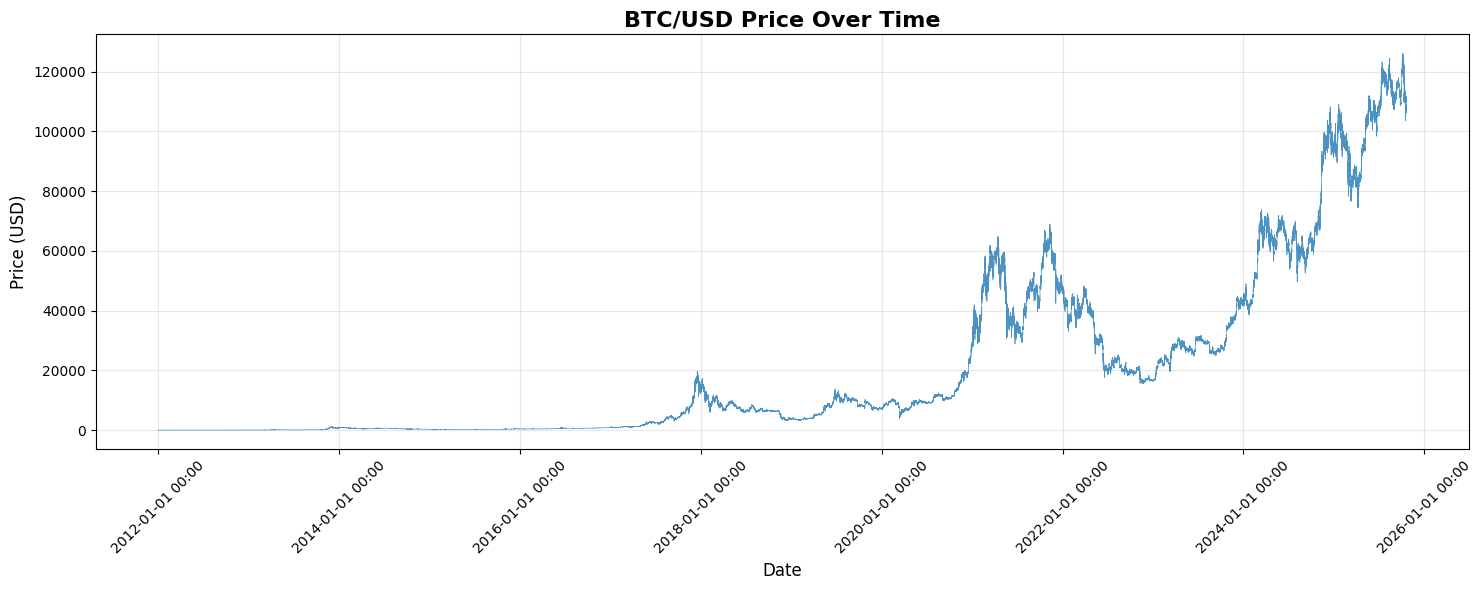

min price: $3.8
max price: $126202.0
mean: $20605.617259248593
std dev: $29161.716912376545


In [ ]:
# plot
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Close'], linewidth=0.5, alpha=0.8)
plt.title('BTC/USD Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/01_btc_price_history.png', dpi=100, bbox_inches='tight')
plt.show()

# stats
print(f"min price: ${df['Close'].min()}")
print(f"max price: ${df['Close'].max()}")
print(f"mean: ${df['Close'].mean()}")
print(f"std dev: ${df['Close'].std()}")

---
## 3. Préparation des données pour LSTM

In [69]:
# Increase to 20000 values for Very Deep Learning
data = df['Close'].values[-20000:].reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"data shape: {scaled_data.shape}")
print(f"min {scaled_data.min()}, max {scaled_data.max()}")

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Increase seq_length from 60 to 120
seq_length = 120
X, y = create_sequences(scaled_data, seq_length)

X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\ntraining shape {X_train.shape}")
print(f"test shape {X_test.shape}")

data shape: (20000, 1)
min 0.0, max 1.0

training shape (15904, 120, 1)
test shape (3976, 120, 1)


---
## 4. Construction du modèle LSTM

In [70]:
# optimisation

# input_layer = Input(shape=(X_train.shape[1], 1))

# # Conv1D
# conv1 = Conv1D(filters=32, kernel_size=3, padding='same')(input_layer)
# conv1 = BatchNormalization()(conv1)
# conv1 = Activation('relu')(conv1)
# conv1 = Dropout(0.2)(conv1)

# # LSTM
# lstm1 = LSTM(units=64, return_sequences=True)(conv1)
# lstm1 = Dropout(0.2)(lstm1)

# lstm2 = LSTM(units=32, return_sequences=False)(lstm1)
# lstm2 = Dropout(0.2)(lstm2)

# # Dense
# dense1 = Dense(units=32, activation='relu')(lstm2)
# dense1 = Dropout(0.1)(dense1)

# output = Dense(units=1)(dense1)

# model = Model(inputs=input_layer, outputs=output)
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# model.summary()

In [71]:
input_layer = Input(shape=(X_train.shape[1], 1))

bloc1 = Conv1D(filters=64, kernel_size=3, padding='same')(input_layer)
bloc1 = BatchNormalization()(bloc1)
bloc1 = Activation('relu')(bloc1)
bloc1 = Dropout(0.2)(bloc1)

bloc2 = Conv1D(filters=64, kernel_size=3, padding='same')(bloc1)
bloc2 = BatchNormalization()(bloc2)
bloc2 = Activation('relu')(bloc2)
bloc2 = Dropout(0.2)(bloc2)

residual1 = Add()([bloc1, bloc2])

lstm1 = LSTM(units=100, return_sequences=True)(bloc2)
lstm1 = Dropout(0.3)(lstm1)

lstm2 = LSTM(units=80, return_sequences=True)(lstm1)
lstm2 = Dropout(0.3)(lstm2)

lstm1_adapted = Conv1D(filters=80, kernel_size=1, padding='same')(lstm1)
residual2 = Add()([lstm1_adapted, lstm2])

lstm3 = LSTM(units=60, return_sequences=False)(residual2)
lstm3 = Dropout(0.3)(lstm3)

dense1 = Dense(units=50, activation='relu')(lstm3)
dense1 = Dropout(0.2)(dense1)

dense2 = Dense(units=25, activation='relu')(dense1)

output = Dense(units=1)(dense2)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 120, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 120, 64)   │        256 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 64)   │        256 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 120, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 120, 64)   │          0 │ activation_15[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 120, 64)   │     12,352 │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 64)   │        256 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 120, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 120, 64)   │          0 │ activation_16[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 120, 100)  │     66,000 │ dropout_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 120, 100)  │          0 │ lstm_24[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 120, 80)   │     57,920 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 120, 80)   │      8,080 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 120, 80)   │          0 │ lstm_25[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 120, 80)   │          0 │ conv1d_23[0][0],  │
│                     │                   │            │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 60)        │     33,840 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 60)        │          0 │ lstm_26[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 50)        │      3,050 │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 50)        │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 183,311 (716.06 KB)

 Trainable params: 183,055 (715.06 KB)

 Non-trainable params: 256 (1.00 KB)

---
## 5. Entraînement du modèle

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0387 - mae: 0.1264
Epoch 1: val_loss improved from None to 0.06308, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - loss: 0.0151 - mae: 0.0820 - val_loss: 0.0631 - val_mae: 0.2467 - learning_rate: 0.0010
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0044 - mae: 0.0483
Epoch 2: val_loss improved from 0.06308 to 0.04754, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - loss: 0.0038 - mae: 0.0445 - val_loss: 0.0475 - val_mae: 0.2141 - learning_rate: 0.0010
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0025 - mae: 0.0358
Epoch 3: val_loss improved from 0.04754 to 0.00845, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0084 - val_mae: 0.0832 - learning_rate: 0.0010
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0020 - mae: 0.

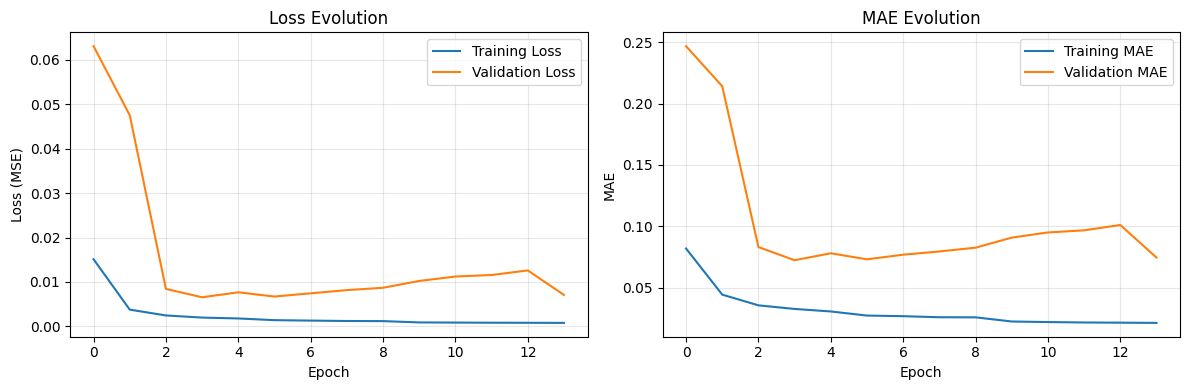

In [72]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    ModelCheckpoint(
        filepath='best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/02_training_history.png', dpi=100, bbox_inches='tight')
plt.show()

---
## 6. Prédictions et évaluation

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
MSE: $641497.4102152283
MAE: $660.0684379715794
RMSE: $800.9353346027558
R2 Score: 0.7752873920158107


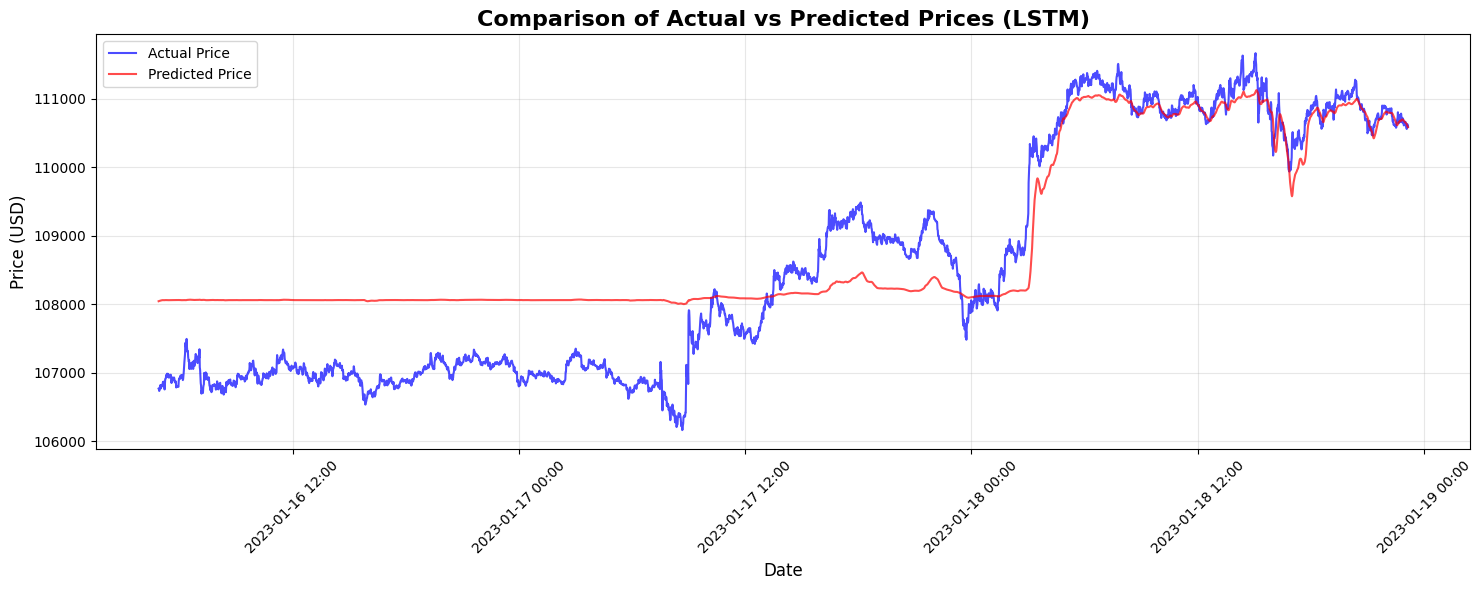

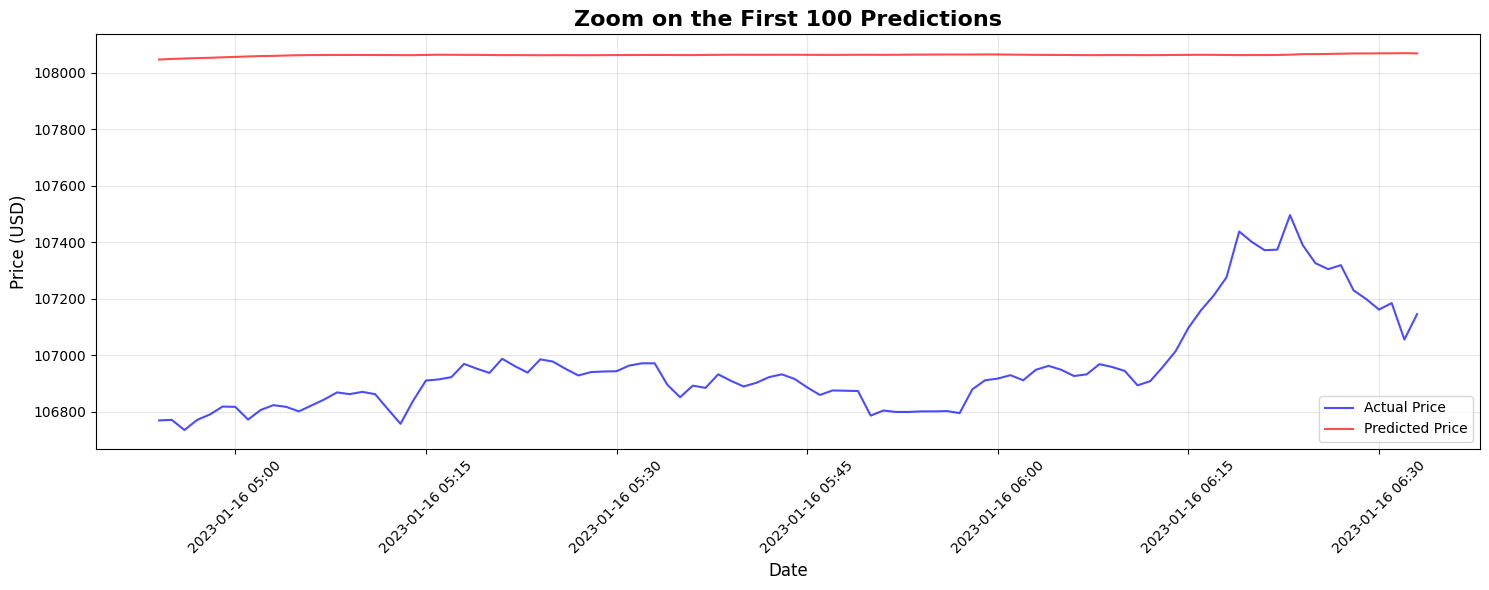

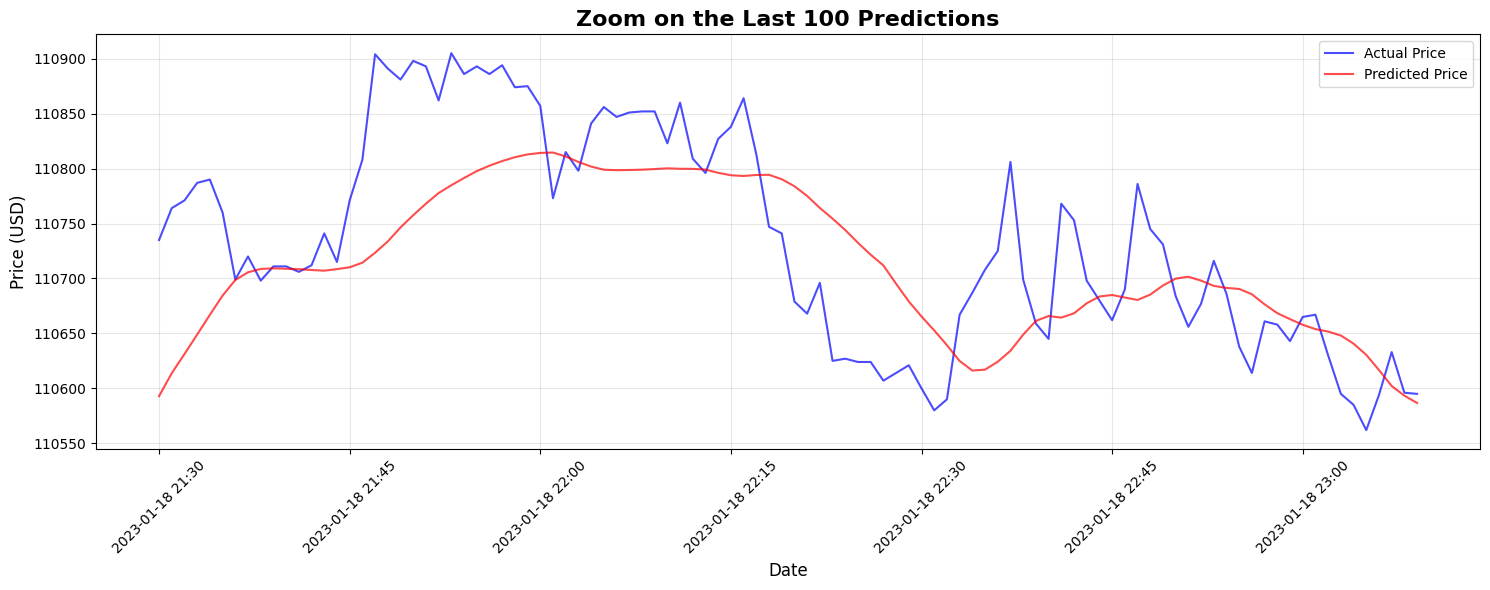

In [73]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get timestamps for test data (correspondant aux prédictions)
test_start_idx = int(0.8 * len(df)) + seq_length + seq_length
test_timestamps = df['Timestamp'].iloc[test_start_idx:test_start_idx + len(predictions)].values

mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"MSE: ${mse}")
print(f"MAE: ${mae}")
print(f"RMSE: ${rmse}")
print(f"R2 Score: {r2}")

# Full predictions with dates
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps, y_test_actual, label='Actual Price', color='blue', alpha=0.7)
plt.plot(test_timestamps, predictions, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual vs Predicted Prices (LSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/03_predictions_full.png', dpi=100, bbox_inches='tight')
plt.show()

# Zoom first 100
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps[:100], y_test_actual[:100], label='Actual Price', color='blue', alpha=0.7)
plt.plot(test_timestamps[:100], predictions[:100], label='Predicted Price', color='red', alpha=0.7)
plt.title('Zoom on the First 100 Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/04_predictions_first_100.png', dpi=100, bbox_inches='tight')
plt.show()

# Zoom last 100
plt.figure(figsize=(15, 6))
plt.plot(test_timestamps[-100:], y_test_actual[-100:], label='Actual Price', color='blue', alpha=0.7)
plt.plot(test_timestamps[-100:], predictions[-100:], label='Predicted Price', color='red', alpha=0.7)
plt.title('Zoom on the Last 100 Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/05_predictions_last_100.png', dpi=100, bbox_inches='tight')
plt.show()

---
## 7. Visualisation avec TensorBoard

In [74]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25380), started 0:53:45 ago. (Use '!kill 25380' to kill it.)